In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import os

# import own libraries
import txtome as tx
import epistasis as epi
import pretty_table as pretty

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [8]:
q = 0.1  # q-value cutoff
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep='\t', comment='#')
quant = pd.read_csv('../input/quantifications.csv')
quant = tx.fc_transcriptome(df=quant)

Dropped 0 rows with NaNs in the b column


# PCA 

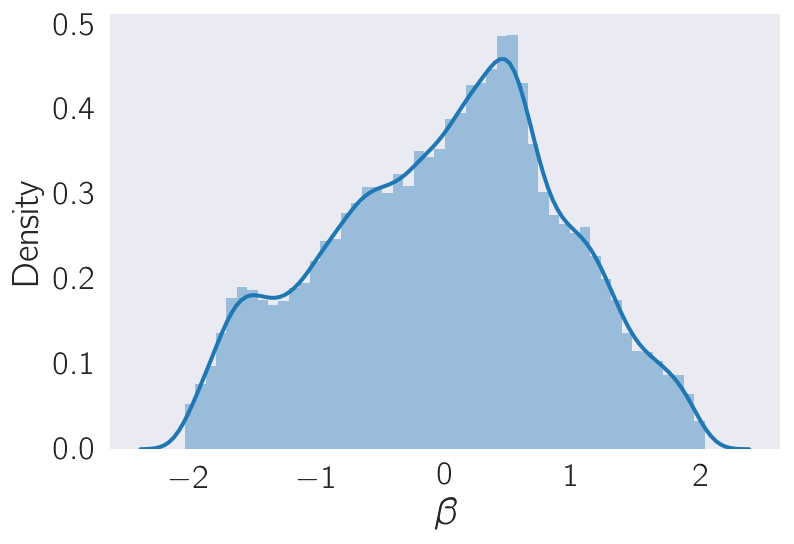

In [9]:
# generate a matrix suitable for PCA cluster
mat = quant.make_matrix(col='fancy')

# visualize distribution to make sure it's not terribly crazy
sns.distplot(mat.as_matrix().reshape(-1, 1))
_ = plt.xlabel(r'$\beta$')
_ = plt.ylabel('Density')

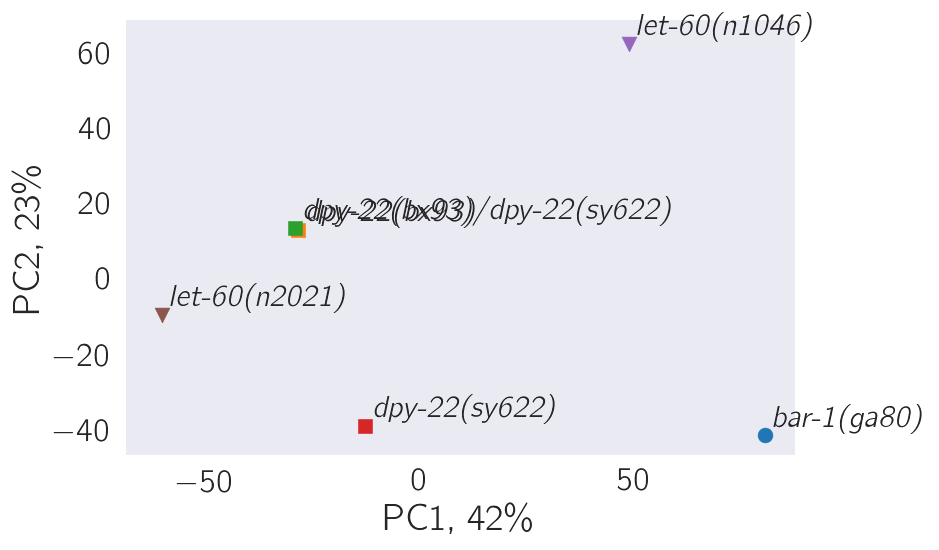

In [25]:
pca = PCA(20)
x = pca.fit_transform(mat.as_matrix().T)

for i, cluster in enumerate(mat.columns):
    # give different marker kinds to each gene
    if 'dpy-22' in cluster:
        m = 's'
    elif 'let-60' in cluster:
        m = 'v'
    else:
        m = 'o'
    
    # make sure the labels come out in italics:
    cluster = r'\emph{' + cluster + '}'
    # plot the points
    plt.scatter(x[i, 0], x[i, 1], marker=m, label=cluster, s=55)
    # also add text to label each point
    plt.annotate(cluster, (x[i, 0]+ 2, x[i, 1]+2), fontsize=15)

# add plot labels
_ = plt.xlabel('PC1, {0:.2g}\%'.format(pca.explained_variance_ratio_[0]*100))
_ = plt.ylabel('PC2, {0:.2g}\%'.format(pca.explained_variance_ratio_[1]*100))

# save
plt.savefig('../output/pca.svg', bbox_inches='tight')

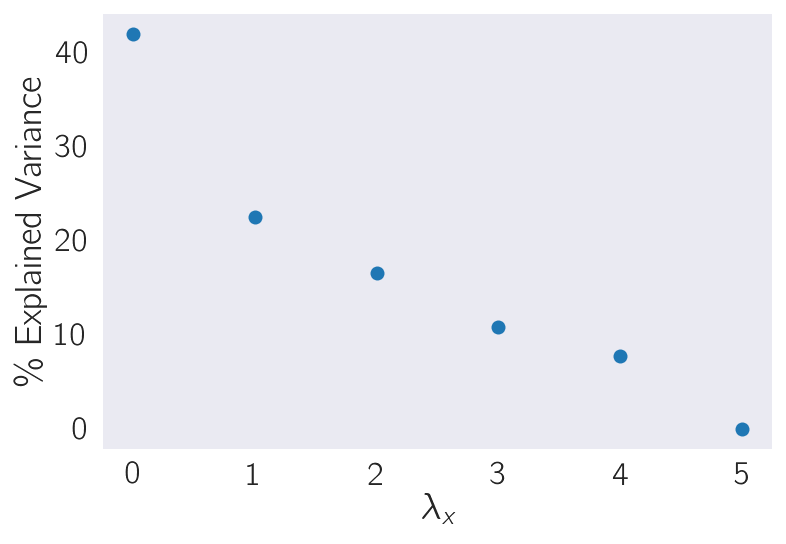

In [13]:
# generate a plot of Explained variance versus Eigenvalue index
plt.plot(pca.explained_variance_ratio_*100, 'o')
_ = plt.xlabel(r'$\lambda_x$')
_ = plt.ylabel(r'\% Explained Variance')

# *dpy-22* alleles' shared transcriptomic phenotypes

In [42]:
def odr(txtome, strain_x, strain_y):
    """
    Calculate a regression line of the STP between strain_x and strain_y
    """
    overlap = txtome.overlap([strain_x, strain_y])
    df = txtome.df[txtome.df.target_id.isin(overlap)]
    tmp = df[df.target_id.isin(overlap)]
    x = df[df.strain == strain_x]
    y = df[df.strain == strain_y]
    res = epi.perform_odr(x.b.values, y.b.values,
                          x.se_b.values, y.se_b.values,
                          beta0=[0.5])
    return res

PS4087 PS4176 836
PS4087 PS4187 189
PS4176 PS4187 192


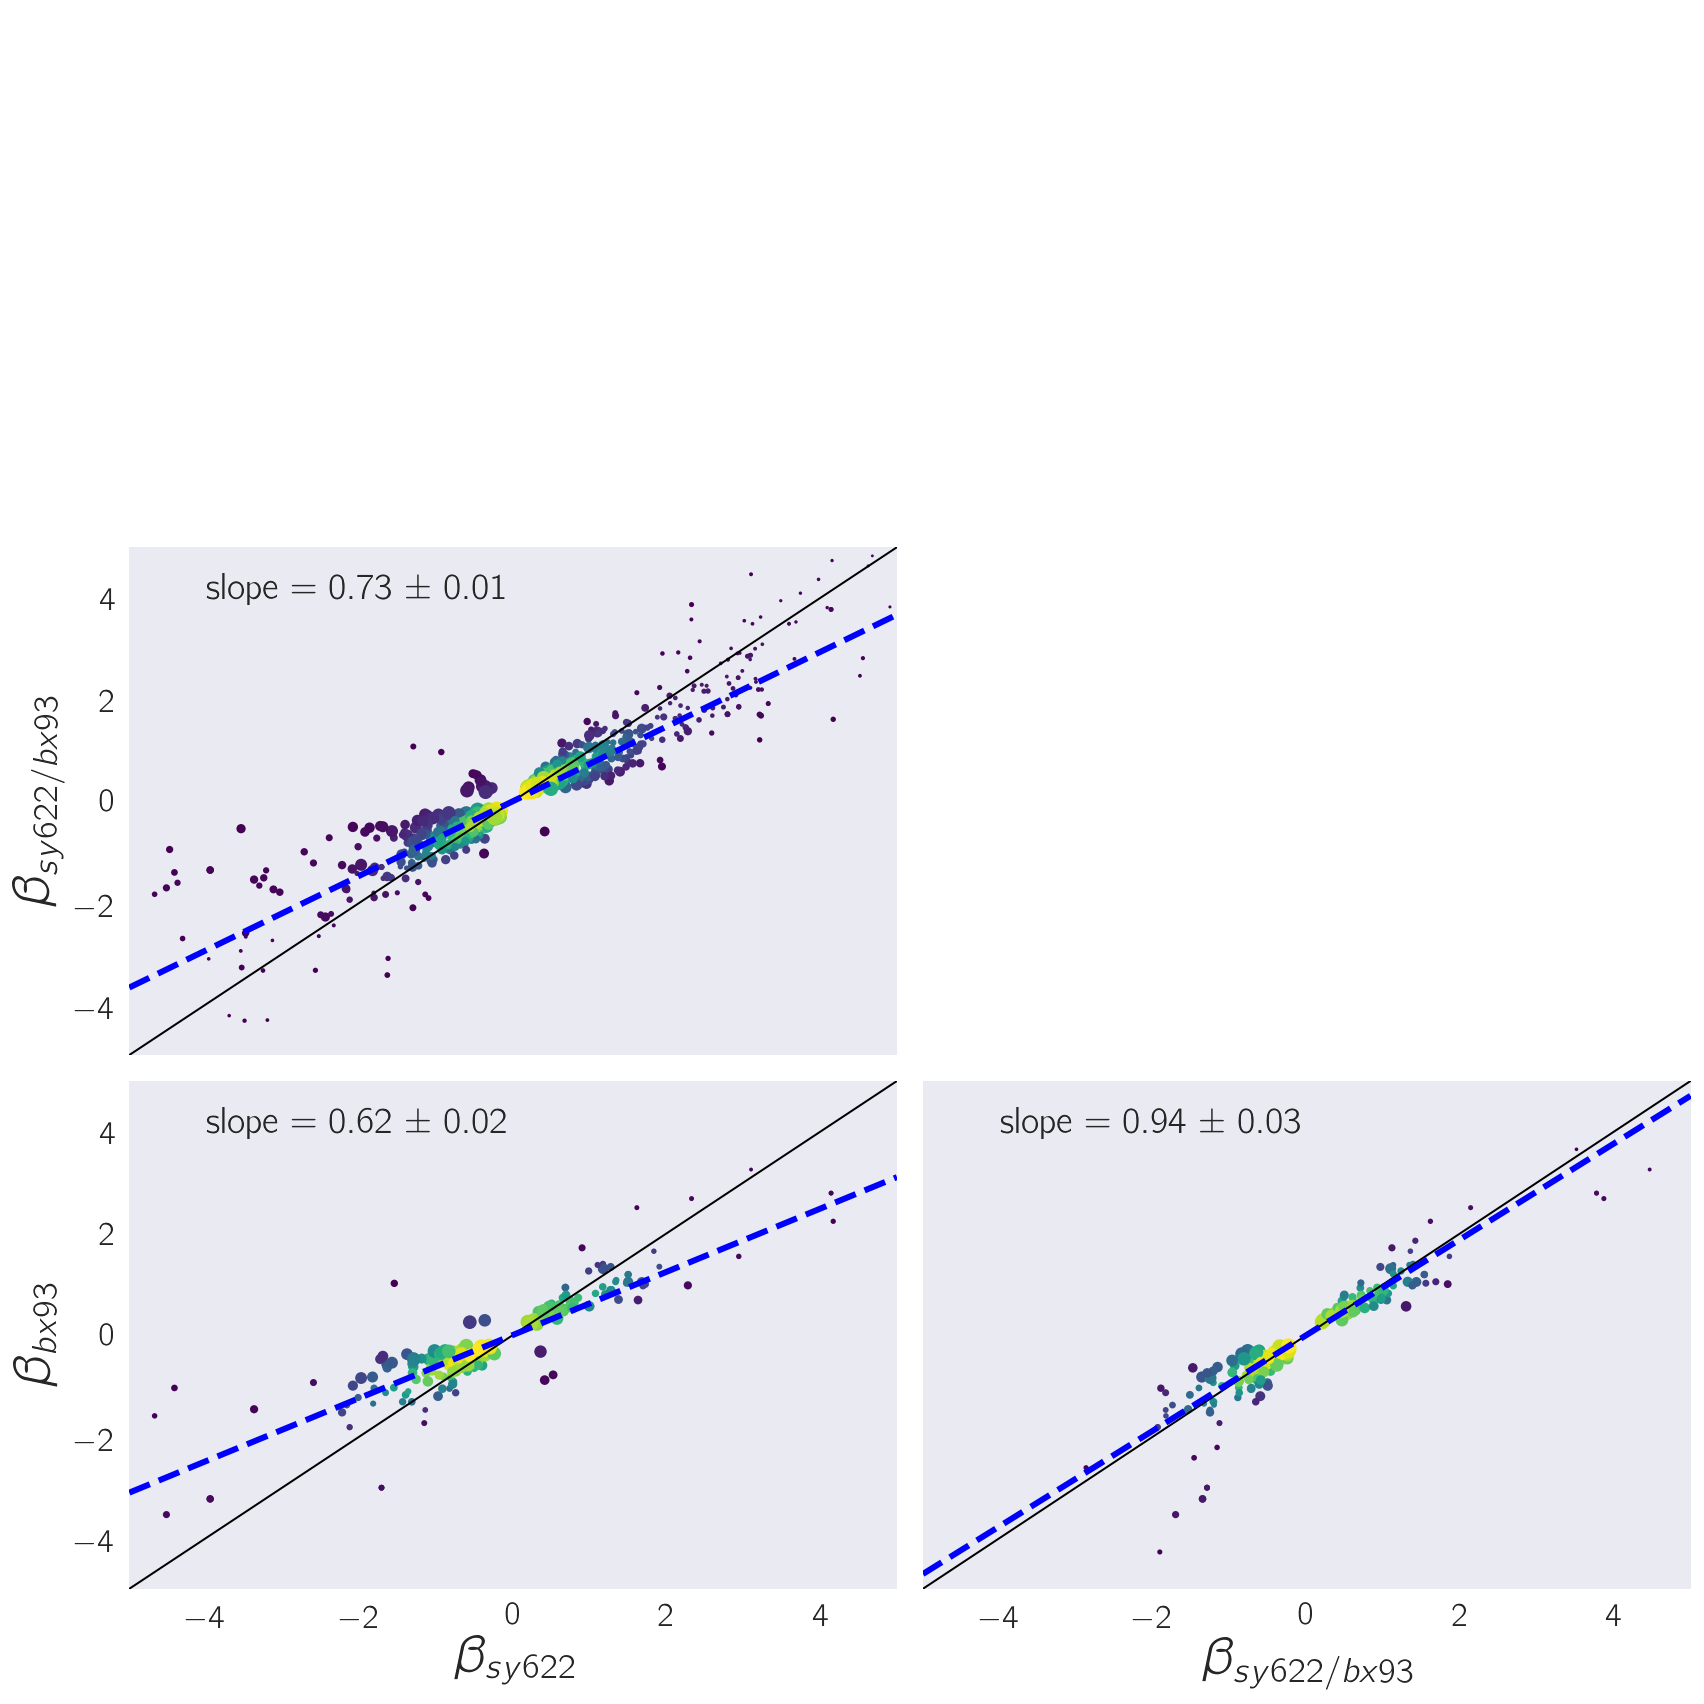

In [47]:
# condition to select the dpy-22 samples:
cond = quant.df.fancy.str.contains('dpy-22')
subset = np.sort(quant.df[cond].strain.unique())

# count the genotypes in this:
n = len(subset)

fig, ax = plt.subplots(nrows=n, ncols=n-1, figsize=(12, 12),
                       sharex=True, sharey=True)

for i, strain in enumerate(subset):
    for j, strain2 in enumerate(subset):
        # turn off upper triangle and diagonal axes
        if i >= j:
            if i < n-1:
                ax[j, i].axis('off')
            continue

        # skip identity
        if strain == strain2:
            continue

        # plot the shared transcriptomic phenotype
        quant.plot_STP(strain, strain2, label=False, ax=ax[j, i], 
                       density=True, cmap='viridis')

        # also plot the line y=x
        x = np.linspace(-5, 5)
        ax[j, i].plot(x, x, color='k', lw=1)
        
        # perform regression
        res = odr(quant, strain, strain2)
        
        # plot the regression and annotate to the corner
        ax[j, i].plot(x, res.beta[0]*x, color='blue', ls='--', lw=3)
        m = 'slope = {0:.2g} $\pm$ {1:.1g}'.format(res.beta[0], 
                                                   res.sd_beta[0])
        ax[j, i].annotate(m, (-4, 4), fontsize=18)

    # find and typeset labels:
    if 'PS4087' in strain:
        genotype = r'$\beta_{sy622}$'
    elif 'PS4187' in strain:
        genotype = r'$\beta_{bx93}$'
    else:
        genotype = r'$\beta_{sy622/bx93}$'
    # label
    if i < n-1:
        ax[n-1, i].set_xlabel(genotype, fontsize=25)
    if i < n:
        ax[i, 0].set_ylabel(genotype, fontsize=25)

plt.xlim(-5, 5) 
plt.ylim(-5, 5)
plt.tight_layout()

plt.savefig('../output/dpy22_STPs.svg', bbox_inches='tight')